In [1]:
%cd /Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK

/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from SYK_fft import *
from ConformalAnalytical import *
import testingscripts

testingscripts.realtimeFFT_validator() # Should return True

True

In [3]:
def rhotosigma(rhoG,rhoD,M,dt,t,g,beta,kappa=1,delta=1e-6):
    '''
    returns [Sigma,Pi] given rhos
    '''
    eta = np.pi/(M*dt)*(0.001)
    rhoGrev = np.concatenate(([rhoG[-1]], rhoG[1:][::-1]))
    rhoFpp = (1/np.pi)*freq2time(rhoG * fermidirac(beta*omega),M,dt)
    rhoFpm = (1/np.pi)*freq2time(rhoG * fermidirac(-1.*beta*omega),M,dt)
    rhoFmp = (1/np.pi)*freq2time(rhoGrev * fermidirac(beta*(omega)),M,dt)
    rhoFmm = (1/np.pi)*freq2time(rhoGrev * fermidirac(-1.*beta*omega),M,dt)
    rhoBpp = (1/np.pi)*freq2time(rhoD * boseeinstein(beta*(omega+eta)),M,dt)
    rhoBpm = (1/np.pi)*freq2time(rhoD * boseeinstein(-1.*beta*(omega+eta)),M,dt)
    
    argSigma = (rhoFpm*rhoBpm - rhoFpp*rhoBpp) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1)
    #argSigma = (rhoFpm*rhoBpm - rhoFpp*rhoBpp) * np.heaviside(t,1)
    Sigma = 1j*(g**2)*kappa * time2freq(argSigma,M,dt)
    
    argPi = (rhoFpp*rhoFmp - rhoFpm*rhoFmm) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1)
    #argPi = (rhoFpp*rhoFmp - rhoFpm*rhoFmm) * np.heaviside(t,1)
    Pi = 2*1j*(g**2) * time2freq(argPi,M,dt)
    
    return [Sigma, Pi]

In [4]:
g = 1.
mu = 0.
#r = 0.001
#r = 0.1 
r = 1.0

beta = 50.

M = int(2**18) #number of points in the grid
T = 2**10 #upper cut-off for the time
dt = (2*T)/((2*M))
t = dt * (np.arange(2*M) - M)

dw = np.pi/(M*dt)
#eta = 1.1011011101111011111 * dw * 0.1
#eta = dw*2.1
#eta = dw*1.000001
#eta = dw*0.1
#eta = dw*1.1
eta = 0.5 * np.pi / beta

omega = dw * (np.arange(2*M) - M) 
np.testing.assert_almost_equal(dt*dw*M,np.pi,5, "Error in fundamentals")
err = 1e-1
print("omega max = ", omega[-1], "dw = ", dw )
print("dt = ", dt)
temp = 1./beta
print("temp/dw = ", temp/dw)
delta = 0.420374134464041
np.testing.assert_almost_equal(np.max(np.abs(omega)),np.pi*M/T,5,"Error in creating omega grid")
Tstar = g**2 * np.sqrt(r)
#
print("Dimensionless coupling g ",g/(r**0.75))
print("Dimensionless temperature ",temp/(r**0.5))

omega max =  804.2446513574113 dw =  0.0030679615757712823
dt =  0.00390625
temp/dw =  6.518986469044034
Dimensionless coupling g  1.0
Dimensionless temperature  0.02


In [5]:
fdplus = np.array([fermidirac(beta*omegaval, default = False) for omegaval in omega])
fdminus = np.array([fermidirac(-1.0*beta*omegaval, default = False) for omegaval in omega])
beplus = np.array([boseeinstein(beta*omegaval, default = False) for omegaval in omega])
beminus = np.array([boseeinstein(-1.0*beta*omegaval, default = False) for omegaval in omega])

def newrhotosigma(rhoG,rhoD,M,dt,t,g,beta,kappa=1,delta=1e-6):
    '''
    returns [Sigma,Pi] given rhos
    '''
    #eta = np.pi/(M*dt)*(0.001)
    rhoGrev = np.concatenate(([rhoG[-1]], rhoG[1:][::-1]))
    rhoFpp = (1/np.pi)*freq2time(rhoG * fdplus,M,dt)
    rhoFpm = (1/np.pi)*freq2time(rhoG * fdminus,M,dt)
    rhoFmp = (1/np.pi)*freq2time(rhoGrev * fdplus,M,dt)
    rhoFmm = (1/np.pi)*freq2time(rhoGrev * fdminus,M,dt)
    rhoBpp = (1/np.pi)*freq2time(rhoD * beplus,M,dt)
    rhoBpm = (1/np.pi)*freq2time(rhoD * beminus,M,dt)
    
    #argSigma = (rhoFpm*rhoBpm - rhoFpp*rhoBpp) * np.exp(-np.abs(delta*t)) * np.heaviside(t,0)
    #argSigma = (rhoFpm*rhoBpm - rhoFpp*rhoBpp) * np.heaviside(t,1)
    argSigma = (rhoFpm*rhoBpm - rhoFpp*rhoBpp) * np.exp(-delta*t) * np.heaviside(t,0)
    Sigma = 1j*(g**2)*kappa * time2freq(argSigma,M,dt)
    
    #argPi = (rhoFpp*rhoFmp - rhoFpm*rhoFmm) * np.exp(-np.abs(delta*t)) * np.heaviside(t,0)
    #argPi = (rhoFpp*rhoFmp - rhoFpm*rhoFmm) * np.heaviside(t,1)
    argPi = (rhoFpp*rhoFmp - rhoFpm*rhoFmm) * np.exp(-delta*t) * np.heaviside(t,0)
    Pi = 2*1j*(g**2) * time2freq(argPi,M,dt)
    
    return [Sigma, Pi]

In [6]:
def RE_LinYSYK_iterator(GRomega,DRomega,g,beta,eta=1e-6, verbose=True):
    
    itern = 0
    omegar2 = ret_omegar2(g,beta)

    diff = 1.
    diffG,diffD = (1,1)
    xG,xD = (0.8,0.8)
    diffseries = []
    flag = True
    while (diff>err and itern<150 and flag): 
        itern += 1 
        diffoldG,diffoldD = (diffG,diffD)
        GRoldomega,DRoldomega = (1.0*GRomega, 1.0*DRomega)

        GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
        DRt = (0.5/np.pi) * freq2time(DRomega,M,dt)
        #rhoG = -1.0*np.imag(GRomega)
        #rhoD = -1.0*np.imag(DRomega)
        rhoG = -np.imag(time2freq(np.exp(eta*t) * GRt, M, dt))
        rhoD = -np.imag(time2freq(np.exp(eta*t) * DRt, M, dt))

        SigmaOmega,PiOmega = newrhotosigma(rhoG,rhoD,M,dt,t,g,beta,kappa=1,delta=eta)

        #PiOmega[M] = 1.0*r - omegar2 - eta**2
        #SigmaOmega[M] = 0
        #PiOmega[M] = 0
        #PiOmega[M] = -1.0*r - omegar2 - eta**2 #modified
        #PiOmega[M] = -1.0*r + omegar2 -eta**2

        # if itern < 10 : 
        #     PiOmega[M] = -1.0*r - omegar2 - eta**2

        GRomega = 1.0*xG/(omega + 1j*eta + mu - SigmaOmega) + (1-xG)*GRoldomega
        DRomega = 1.0*xD/(omega + 1j*eta - PiOmega) + (1-xD)*DRoldomega
        #DRomega = 1.0*xD/(1.0*(omega+1j*eta)**2 - r - PiOmega) + (1-xD)*DRoldomega #modified

    #     GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
    #     DRt = (0.5/np.pi) * freq2time(DRomega,M,dt)
    #     #GRt = GRt - np.real(GRt) # make G(t) purely imaginary 
    #     #DRt = DRt - np.imag(DRt) # make D(t) purely real
    #     #GRt[:M] = 0
    #     #DRt[:M] = 0
    #     GRt[M] = -1j
    #     DRt[M] = 0

        if itern > 10 :
            #GRt = GRt - np.real(GRt) # make G(t) purely imaginary 
            #DRt = DRt - np.imag(DRt) # make D(t) purely real
            #GRt[:M] = 0
            #DRt[:M] = 0
            #GRt[M] = -1j
            #DRt[M] = 0
            #eta=dw*0.01
            eta = eta
            #pass
            # if np.imag(SigmaOmega[M]) > 0 :
            #     raise(Exception('Violation of causality : Pole of Gomega in UHP'))


    #     GRomega = time2freq(GRt,M,dt)
    #     DRomega = time2freq(DRt,M,dt)



        #diffG = np. sqrt((0.5/M) * np.sum((np.abs(GRomega-GRoldomega))**2)) #changed
        #diffD = np. sqrt((0.5/M) * np.sum((np.abs(DRomega-DRoldomega))**2))
        diffG = np. sqrt(np.sum((np.abs(GRomega-GRoldomega))**2)) #changed
        diffD = np. sqrt(np.sum((np.abs(DRomega-DRoldomega))**2))
        #diff = np.max([diffG,diffD])
        diff = 0.5*(diffG+diffD)
        diffG,diffD = diff,diff
        diffseries += [diff]
        flag = testingscripts.diff_checker(diffseries, tol = 1e-3, periods = 5)
        
        if diffG>diffoldG:
            xG/=2.
        if diffD>diffoldD:
            xD/=2.
        if verbose:
            print("itern = ",itern, " , diff = ", diffG, diffD, " , x = ", xG, xD, end = '\r')

    return (GRomega,DRomega)




In [7]:
#GRomega = (-1j)*np.ones(2*M)
#GRomega = time2freq((-1j)*np.ones(2*M)*np.heaviside(t,1.0),M,dt)
#GRomega = time2freq(GRconf(t+1j*delta,J = Jot,beta = beta),M,dt)
#GRomega = 1/(omega + 1j*eta + mu)
#DRomega = 1/(-1.0*(omega + 1j*eta)**2 + r)
#DRomega = -1.0*np.ones(2*M)
#DRomega = time2freq(-1.0*np.ones(2*M)*np.heaviside(t,1.0),M,dt)
#DRomega = DconfImag(-1j*(omega+1j*eta),g,beta)
#GRomega = GconfImag(-1j*(omega+1j*eta),g,beta)
#DRomega = CrazyDconfReal(omega,g,beta,eta)
#GRomega = CrazyGconfReal(omega,g,beta,eta)

GRomega = 1/(omega + 1j*eta + mu)
#GRomega = -(1+1j)*np.ones_like(omega)
#DRomega = -1/(-1.0*(omega + 1j*eta)**2 + r) # modified
#DRomega = 1/(-1.0*(omega + 1j*eta)**2 + r)
DRomega = GRomega.copy()


GRomega, DRomega = RE_LinYSYK_iterator(GRomega,DRomega,g,beta,eta = eta, verbose=True) #updates in place
#eta = dw*0.01

GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
DRt = (0.5/np.pi) * freq2time(DRomega,M,dt)

GRomega = time2freq(np.exp(eta*t) * GRt, M, dt)
DRomega = time2freq(np.exp(eta*t) * DRt, M, dt)

GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
DRt = (0.5/np.pi) * freq2time(DRomega,M,dt)
#GRt = (0.5/np.pi) * freq2time(GRomega - GfreeRealomega(omega,mu,eta),M,dt) + GfreeRealt(t,mu,eta)
#DRt = (0.5/np.pi) * freq2time(DRomega - DfreeRealomega(omega,r,eta),M,dt) + DfreeRealt(t,r,eta)

eta =  0.031415926535897934


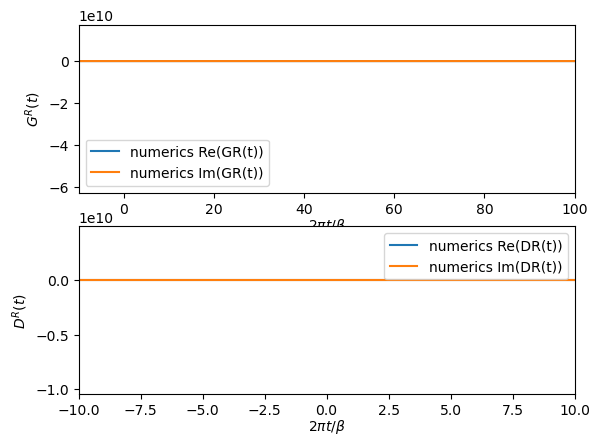

In [8]:
fig, ax = plt.subplots(2)

ax[0].plot(2*np.pi*t/beta, np.real(GRt), label = r'numerics Re(GR(t))')
ax[0].plot(2*np.pi*t/beta, np.imag(GRt), label = r'numerics Im(GR(t))')
#ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax[0].set_ylim(-1,1)
ax[0].set_xlim(-10,100)
ax[0].set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax[0].set_ylabel(r'${G^R(t)}$')
ax[0].legend()

ax[1].plot(2*np.pi*t/beta, np.real(DRt),'-',label = 'numerics Re(DR(t))')
ax[1].plot(2*np.pi*t/beta, np.imag(DRt), label = 'numerics Im(DR(t))')
#ax[1].plot(tau/beta, np.real(Dconftau), 'b--', label = 'analytical Dtau' )
#ax[1].plot(tau/beta, np.real(FreeDtau), 'g-.', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'$2\pi t/\beta$',labelpad = 0)
ax[1].set_ylabel(r'${D^R(t)}$')
#ax[1].set_xlim(0,beta/(2*np.pi))
ax[1].set_xlim(-10,10)
ax[1].legend()

print('eta = ', eta)

In [9]:
np.exp(-np.pi)

0.04321391826377226

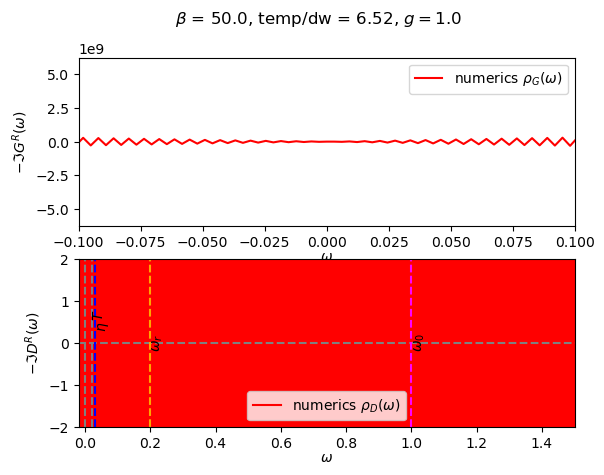

(14349712.744444106+70006.12255584246j)


In [10]:
rhoG, rhoD = -1.0*np.imag(GRomega), -1.0*np.imag(DRomega)
#rhoG, rhoD = -1.0*np.imag(GRomega), 1.0*np.imag(DRomega)
fig, ax = plt.subplots(2)
titlestring = r'$\beta$ = ' + str(beta) + r', temp/dw = ' + f'{(temp/dw):.2f}' + r', $g = $' + str(g)
fig.suptitle(titlestring)
omegar2 = ret_omegar2(g,beta)

match_omega = 0.5
match_point = M + int(np.floor(match_omega/dw))
om_th = np.sqrt(omegar2)
#om_th = 1/beta
#match_coeff = rhoD[match_point]*(np.abs(omega[match_point])**(4*delta-1))
#match_rhoD = match_coeff * np.abs(omega)**(1-4*delta)
match_coeff = rhoD[match_point]*(np.abs(omega[match_point] - om_th + 1j*eta )**(4*delta-1))
match_rhoD = match_coeff * np.abs(omega-om_th)**(1-4*delta)

ax[0].plot(omega, rhoG, 'r', label = r'numerics $\rho_G(\omega)$')
#ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax[0].set_ylim(-1,1)
ax[0].set_xlim(-0.1,0.1)
ax[0].set_xlabel(r'$\omega$',labelpad = 0)
ax[0].set_ylabel(r'$-\Im{G^R(\omega)}$')
ax[0].legend()

ax[1].plot(omega, rhoD, 'r', label = r'numerics $\rho_D(\omega)$')
#ax[1].plot(omega,-np.imag(thermalfreeboson),label = 'free boson with thermal mass')
#ax[1].plot(omega,match_rhoD, c = 'k', ls = '--', label = r'$c |\omega - \omega_r|^{1-4\Delta}$')
#ax[1].plot(omega, np.imag(DfreeRealomega(omega,r,eta=1./beta)), ls = '--', label = 'free boson with bare mass')

#ax[1].set_ylim(-0.2,1.)
ax[1].set_ylim(-2,2)
ax[1].set_xlabel(r'$\omega$',labelpad = 0)
ax[1].set_ylabel(r'$-\Im{D^R(\omega)}$')
ax[1].set_xlim(-0.02,1.5)
ax[1].legend()
ax[1].plot(omega, np.zeros_like(omega),ls = '--', c = 'gray')
ax[1].axvline([0], ls = '--', c = 'gray')
ax[1].axvline([1/beta], ls = '--', c = 'gray')
ax[1].axvline([eta], ls = '--', c = 'blue')
#ax[1].axvline([Tstar], ls = '--', c = 'green')
ax[1].axvline(om_th, ls = '--', c = 'orange')
ax[1].axvline(np.sqrt(r), ls = '--', c = 'magenta')
#ax[1].axvline([omega[peakrhoD[0][-1]]], ls = '--', c = 'black')
ax[1].text(1/beta+0.002,0.6, r'$T$',rotation=90)
ax[1].text(eta+0.001,0.4, r'$\eta$',rotation=90)
ax[1].text(om_th+0.002,-0.1, r'$\omega_r$',rotation=90)
#ax[1].text(Tstar+0.002,0.4, r'$T^{*}$',rotation=90)
ax[1].text(np.sqrt(r)+0.002,-0.1, r'$\omega_0$',rotation=90)

#plt.savefig('KoenraadEmails/RealTimeConvBosonWithMR.pdf')
#plt.savefig('KoenraadEmails/RealTimeConvBosonWithoutMR.pdf')
plt.show()
print(DRomega[-1])

slope of fit = nan
2\Delta - 1 =  -0.15925173107191803


/var/folders/45/s5_xwz0118sg3syff0jyt5wc0000gn/T/ipykernel_32759/1357298271.py:22: RuntimeWarning: invalid value encountered in log
  m,c = np.polyfit(np.log(np.abs(omega[fitslice]+1j*eta)), np.log(functoplot[fitslice]),1)


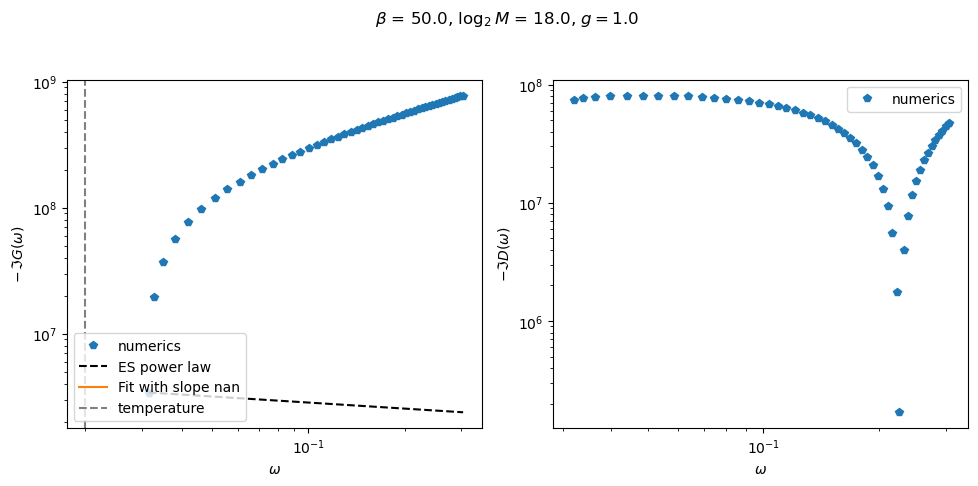

In [11]:


# powD = 1. - 4*Delta
delta = 0.420374134464041
start,stop = M+1, M+100

fitG_val = -np.imag(GRomega[start])
conf_fit_G = 1 * np.abs(omega+1j*eta)**(2*delta - 1)
conf_fit_G = conf_fit_G/conf_fit_G[start] * fitG_val


# fitG_val = np.abs(GRomega[start])
# conf_fit_G = 1 * np.abs(omega+1j*eta)**(2*delta - 1)
# conf_fit_G = conf_fit_G/conf_fit_G[start] * fitG_val

fitD_val = -np.imag(DRomega[start])
conf_fit_D = 1 * np.abs(omega[start:stop]+1j*eta)**(1-4*delta)
conf_fit_D = conf_fit_D/conf_fit_D[0] * fitD_val

#fitslice = slice(start+0, start + 5)
fitslice = slice(start+10, start + 20)
#fitslice = slice(start+25, start + 35)
functoplot = -np.imag(GRomega)
m,c = np.polyfit(np.log(np.abs(omega[fitslice]+1j*eta)), np.log(functoplot[fitslice]),1)
print(f'slope of fit = {m:.03f}')
print('2\Delta - 1 = ', 2*delta-1)

# fitD_val = np.abs(DRomega[start])
# conf_fit_D = 1 * np.abs(omega[start:stop]+1j*eta)**(1-4*delta)
# conf_fit_D = conf_fit_D/conf_fit_D[0] * fitD_val

fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
titlestring = r'$\beta$ = ' + str(beta) + r', $\log_2{M}$ = ' + str(np.log2(M)) + r', $g = $' + str(g)
fig.suptitle(titlestring)
fig.tight_layout(pad=2)

ax1.loglog(np.abs(omega[start:stop]+1j*eta), -np.imag(GRomega[start:stop]),'p',label = 'numerics')
#ax1.loglog(omega[start:stop], np.abs(GRomega[start:stop]),'p',label = 'numerics')
ax1.loglog(np.abs(omega[start:stop]+1j*eta), conf_fit_G[start:stop],'k--',label = 'ES power law')
ax1.loglog(np.abs(omega[start:stop]+1j*eta),np.exp(c)*np.abs(omega[start:stop]+1j*eta)**m, label=f'Fit with slope {m:.03f}')
#ax1.set_xlim(1e-3,1e-1)
ax1.axvline([temp],ls = '--', c= 'gray',label = 'temperature')

ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$-\,\Im{G(\omega)}$')
#ax1.set_ylabel(r'$|G(\omega)|$')
#ax1.set_aspect('equal', adjustable='box')
#ax1.axis('square')
ax1.legend(loc = 'lower left')
#ax1.text(0.05,100,f'slope of fit = {m:.03f}')

ax2.loglog(np.abs(omega[start:stop]+1j*eta), -np.imag(DRomega[start:stop]),'p',label='numerics')
#ax2.loglog(omega[start:stop], np.abs(DRomega[start:stop]),'p',label='numerics')
#ax2.loglog(np.abs(omega[start:stop]+1j*eta), conf_fit_D,'k--',label = 'ES power law')

ax2.set_xlabel(r'$\omega$')
ax2.set_ylabel(r'$-\Im{D(\omega)}$',labelpad = None)
#ax2.set_ylabel(r'$|D(\omega)|$',labelpad = None)
#ax2.set_aspect('equal', adjustable='box')
ax2.legend(loc = 'upper right')

#plt.savefig('KoenraadEmails/PowerLawRealTimeConvBosonWithMR.pdf')
#plt.savefig('KoenraadEmails/PowerLawRealTimeConvBosonWithoutMR.pdf')

In [12]:
SigmaOmega,PiOmega = rhotosigma(rhoG,rhoD,M,dt,t,g,beta,kappa=1,delta=eta)
PiOmega[M], omega[M], omegar2

/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:87: RuntimeWarning: overflow encountered in exp
  return (1.0/(1.0 + np.exp(arg)))
/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:102: RuntimeWarning: overflow encountered in exp
  return (1.0/(np.exp(arg)-1))


((-2118107.9969146526-4594558.690427819j), 0.0, 0.03902088852134805)

slope of fit = nan
2\Delta - 1 =  -0.15925173107191803


/var/folders/45/s5_xwz0118sg3syff0jyt5wc0000gn/T/ipykernel_32759/3788479628.py:8: RuntimeWarning: divide by zero encountered in power
  conf_fit_G = 1 * np.abs(omega)**(2*delta - 1)
/var/folders/45/s5_xwz0118sg3syff0jyt5wc0000gn/T/ipykernel_32759/3788479628.py:24: RuntimeWarning: invalid value encountered in log
  m,c = np.polyfit(np.log(np.abs(omega[fitslice])), np.log(functoplot[fitslice]),1)


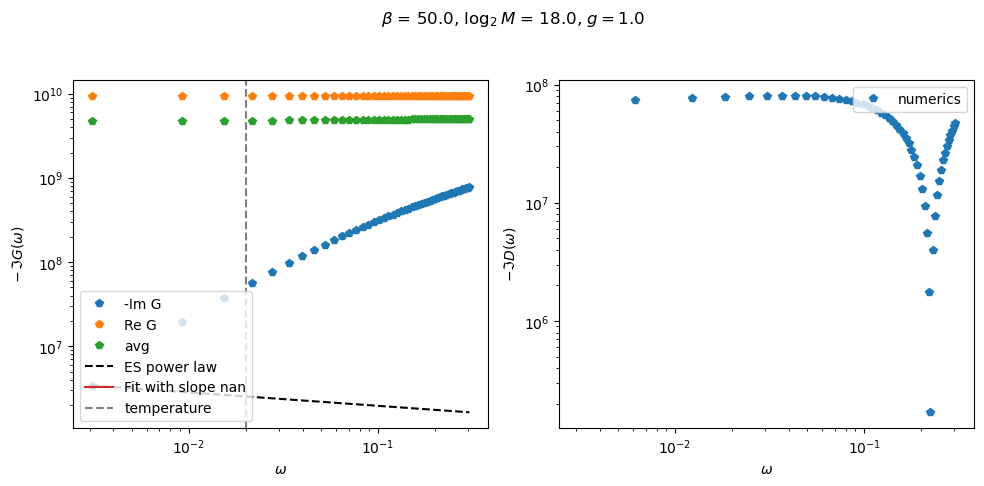

In [13]:
# powD = 1. - 4*Delta
delta = 0.420374134464041
start,stop = M+1, M+100

avg = 0.5*(np.real(GRomega)- np.imag(GRomega))

fitG_val = -np.imag(GRomega[start])
conf_fit_G = 1 * np.abs(omega)**(2*delta - 1)
conf_fit_G = conf_fit_G/conf_fit_G[start] * fitG_val


fitD_val = -np.imag(DRomega[start])
conf_fit_D = 1 * np.abs(omega[start:stop])**(1-4*delta)
conf_fit_D = conf_fit_D/conf_fit_D[0] * fitD_val

#meet_idx= omega_idx(min(abs(np.real(GRomega)+np.imag(GRomega))), dw, M)
meet_idx = omega_idx(temp,dw,M)

fitslice = slice(meet_idx, meet_idx + 15)
#fitslice = slice(start+10, start + 20)
#fitslice = slice(start+25, start + 35)
#functoplot = -np.imag(GRomega)
functoplot = avg
m,c = np.polyfit(np.log(np.abs(omega[fitslice])), np.log(functoplot[fitslice]),1)
print(f'slope of fit = {m:.03f}')
print('2\Delta - 1 = ', 2*delta-1)

# fitD_val = np.abs(DRomega[start])
# conf_fit_D = 1 * np.abs(omega[start:stop]+1j*eta)**(1-4*delta)
# conf_fit_D = conf_fit_D/conf_fit_D[0] * fitD_val

fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
titlestring = r'$\beta$ = ' + str(beta) + r', $\log_2{M}$ = ' + str(np.log2(M)) + r', $g = $' + str(g)
fig.suptitle(titlestring)
fig.tight_layout(pad=2)

ax1.loglog(np.abs(omega[start:stop]), -np.imag(GRomega[start:stop]),'p',label = '-Im G')
ax1.loglog(np.abs(omega[start:stop]), np.real(GRomega[start:stop]),'p',label = 'Re G')
ax1.loglog(np.abs(omega[start:stop]), avg[start:stop],'p',label = 'avg')

#ax1.loglog(omega[start:stop], np.abs(GRomega[start:stop]),'p',label = 'numerics')
ax1.loglog(np.abs(omega[start:stop]), conf_fit_G[start:stop],'k--',label = 'ES power law')
ax1.loglog(np.abs(omega[start:stop]),np.exp(c)*np.abs(omega[start:stop])**m, label=f'Fit with slope {m:.03f}')
#ax1.set_xlim(1e-3,1e-1)
ax1.axvline([temp],ls = '--', c= 'gray',label = 'temperature')

ax1.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$-\,\Im{G(\omega)}$')
#ax1.set_ylabel(r'$|G(\omega)|$')
#ax1.set_aspect('equal', adjustable='box')
#ax1.axis('square')
ax1.legend(loc = 'lower left')
#ax1.text(0.05,100,f'slope of fit = {m:.03f}')

ax2.loglog(np.abs(omega[start:stop]), -np.imag(DRomega[start:stop]),'p',label='numerics')
#ax2.loglog(omega[start:stop], np.abs(DRomega[start:stop]),'p',label='numerics')
#ax2.loglog(np.abs(omega[start:stop]+1j*eta), conf_fit_D,'k--',label = 'ES power law')

ax2.set_xlabel(r'$\omega$')
ax2.set_ylabel(r'$-\Im{D(\omega)}$',labelpad = None)
#ax2.set_ylabel(r'$|D(\omega)|$',labelpad = None)
#ax2.set_aspect('equal', adjustable='box')
ax2.legend(loc = 'upper right')

#plt.savefig('KoenraadEmails/PowerLawRealTimeConvBosonWithMR.pdf')
#plt.savefig('KoenraadEmails/PowerLawRealTimeConvBosonWithoutMR.pdf')

In [14]:
arr = np.arange(5)
arr[::-1]


array([4, 3, 2, 1, 0])

In [15]:
omega_idx(min(abs(avg)), dw, M)

267257

In [16]:
omega_idx?

Signature: omega_idx(omegaval, dw, M)
Docstring:
returns the index of omegaval on the conventional omega grid
omega[M] = 0
File:      ~/Documents/GitHub/TwoSidedYSYK/SYK_fft.py
Type:      function

In [17]:
boseeinstein(beta*50)

0.0

/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:102: RuntimeWarning: divide by zero encountered in divide
  return (1.0/(np.exp(arg)-1))


(-1.0, 1.0)

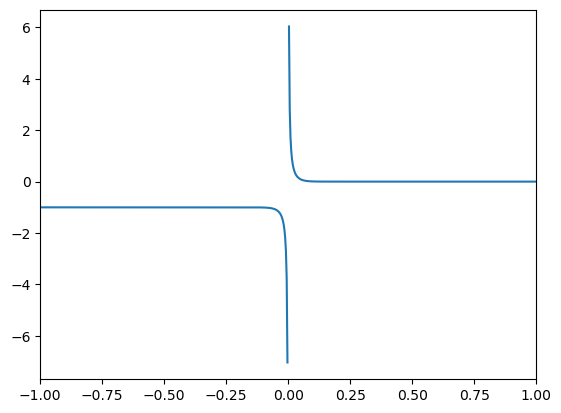

In [18]:
#implement rhotosigma for yukawa SYK without using the bose-einstein function 
plt.plot(omega, boseeinstein(beta*omega))
plt.xlim(-1,1)

In [19]:
print("Thermal mass = ", om_th)

Thermal mass =  0.19753705607138133
